<a href="https://colab.research.google.com/github/sara-velmont/analisis_red_Quimica/blob/main/Gr%C3%A1ficas_Congreso.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np #operaciones matemáticas
import networkx as nx #Para manejo de redes
import matplotlib.pyplot as plt #Para gráficas y edición
import pandas as pd #para manejos de datos

#**Red Real**

In [ ]:
datos = pd.read_csv('Enlaces de Red de Química 09-23.csv', header=None)

In [ ]:
GR = nx.from_pandas_edgelist(datos, source= 0, target= 1)
for nodo in datos:  #Añadiendo el nodo 32 que no tiene enlaces
    GR.add_node(32)

In [ ]:
#Medidas globales:
N = nx.number_of_nodes(GR)
#La red tiene componentes, algunos grupos de nodos no están conectados
componentes = list(nx.connected_components(GR))
diametros_componentes = []
dis_prom_comp = []
for componente in componentes:
    subgrafo = GR.subgraph(componente)
    diametro = nx.diameter(subgrafo)
    dis_prom = nx.average_shortest_path_length(subgrafo)
    diametros_componentes.append(diametro)
    dis_prom_comp.append(dis_prom)

componente_mas_grande = max(componentes, key=len)
G2 = GR.subgraph(componente_mas_grande)

#Parámetros para promedio pesado:
C1 = 40*dis_prom_comp[0]
C2 = 3*dis_prom_comp[1]
C3 = 1*dis_prom_comp[2]

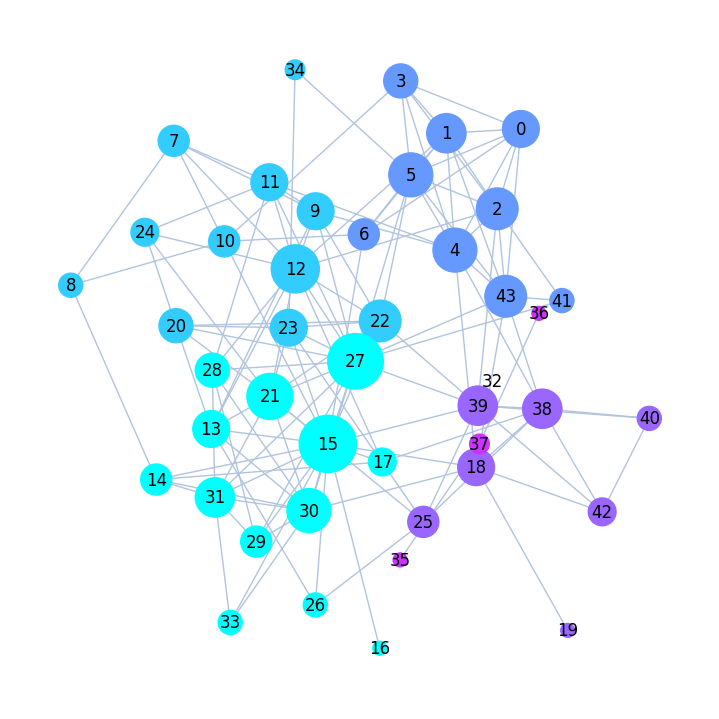

In [ ]:
from networkx.algorithms.community import greedy_modularity_communities
comunidades = greedy_modularity_communities(GR)
Com = {}

for i, comunidad in enumerate(comunidades):
  for nodo in comunidad:
    Com[nodo] = i

#Asigando un color a cada comunidad detectada
colors = np.array([Com[i] for i in GR ])
Degree =nx.degree(GR)
sizes = np.array([Degree[i] for i in GR])
plt.figure(figsize = [7,7])

pos = nx.kamada_kawai_layout(GR)

nx.draw(GR, pos, with_labels=True, node_color=colors, cmap='cool', node_size=100*sizes,
        edge_color= 'lightsteelblue')

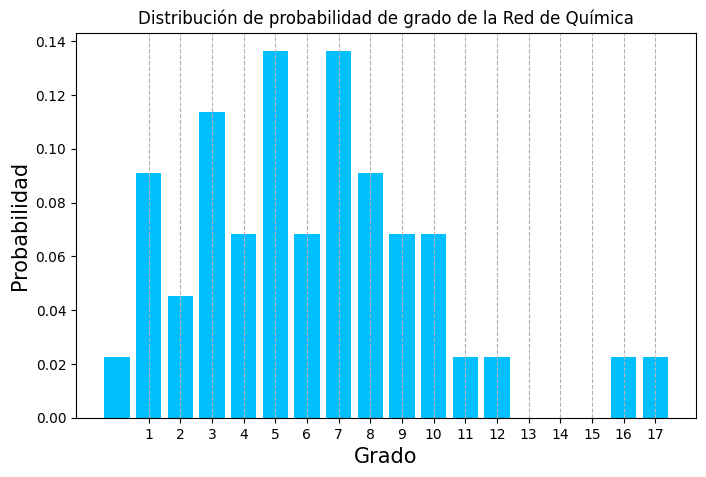

In [ ]:
#Distribución de grado
Degree = dict(GR.degree)
grados = [Degree[i] for i in GR]
distribucion = {}
for i in grados: #este bucle únicamente genera las claves del diccionario, asignándoles un valor de 0
  distribucion[i] = 0
for i in grados: #este bucle recorre todos los grados y cada vez que un valor aparece, suma uno a la cuenta de ese valor
  distribucion[i] += 1

#Distribución de probabilidad de grado

distribucion_probabilidad = {k: v / 44 for k, v in distribucion.items()}

X = distribucion_probabilidad.keys()
Y = distribucion_probabilidad.values()

plt.figure(figsize = [8, 5])

plt.bar(X,Y, color = 'deepskyblue')

plt.grid(axis = 'x', linestyle='--')
plt.xlabel('Grado', size = 15)
plt.ylabel('Probabilidad', size = 15)
plt.xticks(ticks = range(1,max(X)+1),labels = range(1,max(X)+1))
plt.yticks(size = 10)
plt.title('Distribución de probabilidad de grado de la Red de Química')
plt.show()

In [ ]:
y, x = np.histogram([dict(GR.degree)[i] for i in GR], bins = range(N))
DP_Real = y/44

#**Modelo Erdős-Rényi**

In [ ]:
#Red aleatoria G(N,p)
def enlaces_aleatorios(N, p):
  for i in range(N):
    for j in range(i):
      if np.random.rand() < p:
         yield i,j

def red_aleatoria(N, p):
  GER = nx.Graph()
  GER.add_nodes_from(range(N))
  GER.add_edges_from( enlaces_aleatorios(N, p) )

  return GER

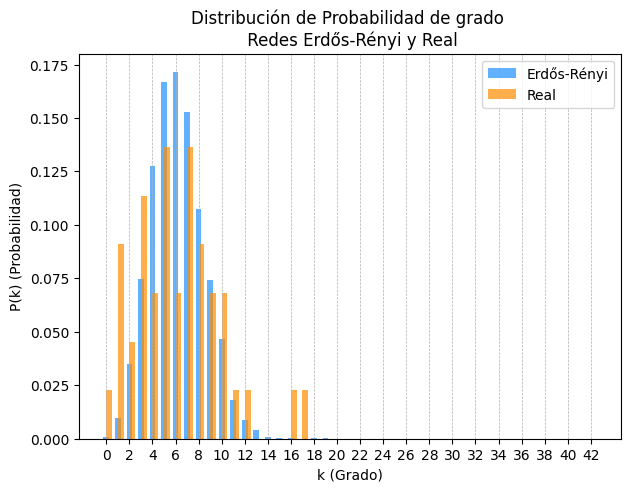

In [ ]:
#Generación de un ensamble
N = 44
p = 0.1427061310782241 #Cálculo de probabilidad p=2L/[N(N-1)]
corridas = 200


Y2 = np.zeros(N-1) #Arreglo de ceros de longitud N-1 (los grados sólo pueden ir de 0 a N-1)

for i in range(corridas):
    GER = red_aleatoria(N,p)
    y2, x2 = np.histogram([dict(GER.degree)[i] for i in GER], bins = range(N))
    Y2 += y2
Y2 = Y2/corridas #Esto da la distribución promedio sobre todas las corridas

DP_ER = Y2 / N # Normalización y Definición de D. de Probabilidad de Grado

plt.figure(figsize=[7, 5])

# Grafica la distribución de probabilidad de grado
plt.bar(x2[:-1],DP_ER, width=0.5, align='center', color = 'dodgerblue', alpha=0.7, label='Erdős-Rényi')

# Grafica la distribución de probabilidad binomial
plt.bar(x2[:-1], DP_Real, width=0.5, align='edge', color = 'darkorange', alpha=0.7, label='Real')

plt.grid(axis='x', linestyle='--', linewidth=0.5)
x_ticks = np.arange(0, 43, 2)
plt.xticks(x_ticks)
plt.xlabel('k (Grado)')
plt.ylabel('P(k) (Probabilidad)')
plt.title('Distribución de Probabilidad de grado \n Redes Erdős-Rényi y Real')
plt.legend()

plt.show()

#**Modelo Watts-Strogatz**

In [ ]:
#Definición para generar un grafo anillo
def Anillo(N, l):
    nodos = np.arange(N)
    GA = nx.Graph()
    GA.add_nodes_from( nodos )

    for i in range(l):
        GA.add_edges_from( zip( nodos, np.roll(nodos, i+1) ) )
    return GA

In [ ]:
#Función de cambio de enlaces establecidos de acuerdo a la probabilidad p
def re_enlazar(GA, p):
  nodos = set(GA)

  for enlace in GA.edges():
    if np.random.rand() < p:
      u, v = enlace
      eleccion = nodos -{u} - set(GA[u])
      nuevo_v = np.random.choice( list(eleccion) )
      GA.remove_edge(u,v)
      GA.add_edge(u, nuevo_v)

In [ ]:
#Asignación de parámetros
N = 44 #nodos
l = 3 #Se desconecta la red para ordenes menores de vecindad
GA = Anillo(N, l) #Red anillo con los parámetros dados
arreglo=np.logspace(-4,0,100) #Rango de valores para la probabilidad
corridas=200 #Número de realizaciones

Clus_valores=[]
Dist_sum = []
Dist_valores = []

for p in arreglo:
  Clus_sum= 0
  Dist_sum = 0
  for i in range(corridas):
    GWS = GA.copy()
    re_enlazar(GWS,p)
    componentesWS = list(nx.connected_components(GWS))
    Dis_pprom_comp = []
    for componente in componentesWS:
      subgrafo = GWS.subgraph(componente)
      num_nodos = len(subgrafo.nodes)
      dis_prom = nx.average_shortest_path_length(subgrafo)
      peso = num_nodos * dis_prom  # Ponderación por el número de nodos
      Dis_pprom_comp.append(peso)
    suma_pesos = sum(Dis_pprom_comp)
    suma_nodos = sum(len(subgrafo) for subgrafo in componentesWS)
    distancia_promedio_ponderada = suma_pesos / suma_nodos

    Clus = nx.average_clustering(GWS)
    Clus_sum += Clus
    Dist_sum += distancia_promedio_ponderada

  Clus_prom = Clus_sum/corridas
  Dist_prom = Dist_sum/corridas
  Clus_valores.append(Clus_prom)
  Dist_valores.append(Dist_prom)

In [ ]:
Clus_valores = np.array(Clus_valores)
ScaleClus = Clus_valores/Clus_valores[0]

Dist_valores = np.array(Dist_valores)
ScaleDist = Dist_valores/Dist_valores[0]

In [ ]:
pmin = 0.170735 #Para una red de Ws con Clustering aprox 0.387
pmax = 1	#Para una red WS con distancia promedio aprox 2.1
pmp = 0.0509413801481638 #p de mundo pequeño

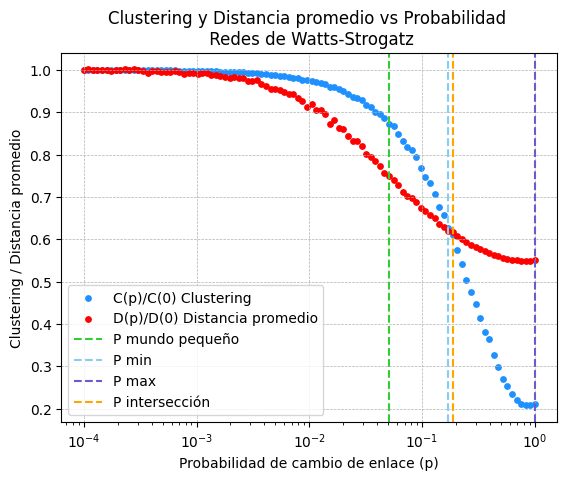

In [ ]:
plt.scatter(arreglo, ScaleClus, color='dodgerblue', s=15, label='C(p)/C(0) Clustering')
plt.scatter(arreglo, ScaleDist, color='red',  s=15, label='D(p)/D(0) Distancia promedio')
plt.axvline(x = 0.0509413801481638, color='limegreen', linestyle='--', label='P mundo pequeño') #No se tomó en cuenta el criterio anterior, sino el que se muestra más adelante
plt.axvline(x = 0.170735, color='skyblue', linestyle='--', label='P min')
plt.axvline(x = 1, color='slateblue', linestyle='--', label='P max')
plt.axvline(x = 0.1873817422860385, color='orange', linestyle='--', label='P intersección')

plt.grid(linestyle='--', linewidth=0.5)
plt.xscale('log')
plt.xlabel('Probabilidad de cambio de enlace (p)')
plt.ylabel('Clustering / Distancia promedio')

plt.title('Clustering y Distancia promedio vs Probabilidad \n Redes de Watts-Strogatz')

plt.legend()
plt.show()

In [ ]:
Y3 = np.zeros(N-1)
#WS Con p min
for i in range(corridas):
    GWS = GA.copy()
    re_enlazar(GWS,pmin)
    y3, x3 = np.histogram([dict(GWS.degree)[i] for i in GWS], bins = range(N))
    Y3 += y3
Y3 = Y3/corridas

DP_WSpmin = Y3 / N #Def de Distribución de probabilidad W-S min

Y4 = np.zeros(N-1)
#WS Con p max
for i in range(corridas):
    GWS = GA.copy()
    re_enlazar(GWS,pmax)
    y4, x4 = np.histogram([dict(GWS.degree)[i] for i in GWS], bins = range(N))
    Y4 += y4
Y4 = Y4/corridas

DP_WSpmax = Y4 / N #Def de Distribución de probabilidad W-S max

Y5 = np.zeros(N-1)
#WS Con p max
for i in range(corridas):
    GWS = GA.copy()
    re_enlazar(GWS,pmax)
    y5, x5 = np.histogram([dict(GWS.degree)[i] for i in GWS], bins = range(N))
    Y5 += y5
Y5 = Y5/corridas

DP_WSpmp = Y5 / N #Def de Distribución de probabilidad W-S mundo pequeño

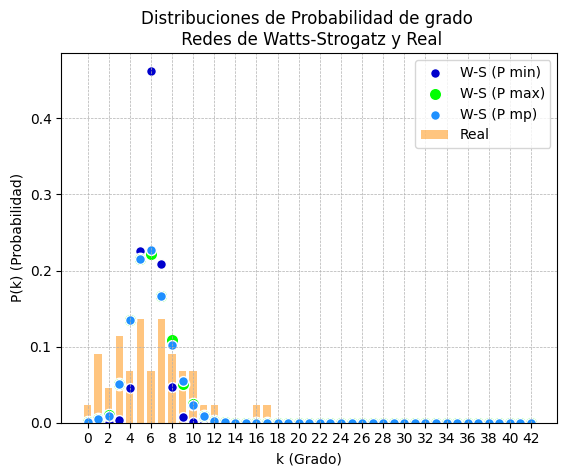

In [ ]:
plt.bar(x3[:-1], DP_Real, color='darkorange',  width=0.7, align='center', alpha=0.5, label='Real')
plt.scatter(x3[:-1], DP_WSpmin, color='mediumblue', s=50, marker='o', label='W-S (P min)', edgecolors = 'white', linewidths = 1)
plt.scatter(x3[:-1], DP_WSpmax, color='lime', s=80, marker='o', label='W-S (P max)', edgecolors = 'white', linewidths = 1)
plt.scatter(x3[:-1], DP_WSpmp, color='dodgerblue', s=50, marker='o', alpha = 1, label='W-S (P mp)', edgecolors = 'white', linewidths = 1)

plt.grid(linestyle='--', linewidth=0.5)
x_ticks = np.arange(0, 43, 2)
plt.xticks(x_ticks)
plt.xlabel('k (Grado)')
plt.ylabel('P(k) (Probabilidad)')
plt.title('Distribuciones de Probabilidad de grado \n Redes de Watts-Strogatz y Real')
plt.legend()

plt.show()

#**Modelo de Barabasi-Albert**

In [ ]:
from itertools import permutations

def generar_red_barabasi(m0, m, n):
    # Creación de la semilla
    GB = nx.Graph()

    for i in range(m0):
        GB.add_node(i)
    GB.add_edges_from(list(permutations(list(GB), 2)))

    for i in range(len(GB), n):
        grados = np.array(list(dict(GB.degree).values()))
        probabilidades = grados / sum(grados)
        nodos = np.random.choice(list(GB), size=m, p=probabilidades, replace=False)
        GB.add_node(i)
        for j in nodos:
            GB.add_edge(i, j)

    return GB

In [ ]:
#Redes de Barabasi con m0=4 y m=4
corridas = 200
Y6 = np.zeros(N-1)
for _ in range(corridas):
    red_barabasi = generar_red_barabasi(3, 3, N)
    y6, x6 = np.histogram([dict(red_barabasi.degree)[i] for i in red_barabasi], bins = range(N))
    Y6 += y6
Y6 = Y6/corridas #Esto da la distribución promedio sobre todas las corridas
DP_BA33 = Y6 / N # Definición 3,3

Y7 = np.zeros(N-1)
for _ in range(corridas):
    red_barabasi = generar_red_barabasi(4, 4, N)
    y7, x7 = np.histogram([dict(red_barabasi.degree)[i] for i in red_barabasi], bins = range(N))
    Y7 += y7
Y7 = Y7/corridas
DP_BA44 = Y7 / N

#Redes de Barabasi con m0=4 y m=3
Y8 = np.zeros(N-1)
for _ in range(corridas):
    red_barabasi = generar_red_barabasi(4, 3, N)
    y8, x8 = np.histogram([dict(red_barabasi.degree)[i] for i in red_barabasi], bins = range(N))
    Y8 += y8
Y8 = Y8/corridas
DP_BA43 = Y8 / N

#Redes de Barabasi con m0=5 y m=5
Y9 = np.zeros(N-1)
for _ in range(corridas):
    red_barabasi = generar_red_barabasi(5, 5, N)
    y9, x9 = np.histogram([dict(red_barabasi.degree)[i] for i in red_barabasi], bins = range(N))
    Y9 += y9
Y9 = Y9/corridas
DP_BA55 = Y9 / N

#Redes de Barabasi con m0=5 y m=4
Y10 = np.zeros(N-1)
for _ in range(corridas):
    red_barabasi = generar_red_barabasi(5, 4, N)
    y10, x10 = np.histogram([dict(red_barabasi.degree)[i] for i in red_barabasi], bins = range(N))
    Y10 += y10
Y10 = Y10/corridas
DP_BA54 = Y10 / N

#Redes de Barabasi con m0=5 y m=3
Y11 = np.zeros(N-1)
for _ in range(corridas):
    red_barabasi = generar_red_barabasi(5, 3, N)
    y11, x11 = np.histogram([dict(red_barabasi.degree)[i] for i in red_barabasi], bins = range(N))
    Y11 += y11
Y11 = Y11/corridas
DP_BA53 = Y11 / N

<ipython-input-30-383871fda956>:5: RuntimeWarning: divide by zero encountered in log
  log_B33 = np.log(DP_BA33)


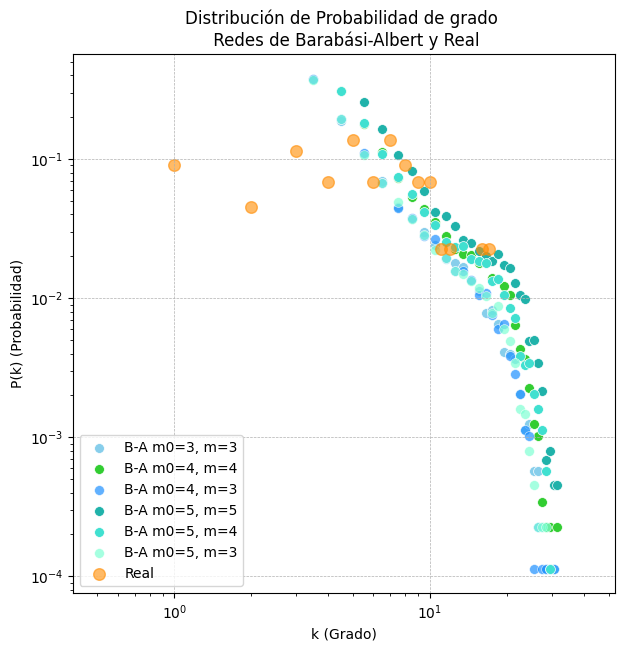

In [ ]:
plt.figure(figsize = [7,7])

x_med = (x6[:-1] + x6[1:])*.5
log_x = np.log(x_med)
log_B33 = np.log(DP_BA33)
pendiente, ordenada_al_origen = np.polyfit(log_x, log_B33, 1)

plt.scatter(x_med, DP_BA33, color='skyblue', s=50, marker='o', label='B-A m0=3, m=3', edgecolors = 'white', linewidths = 0.5)
plt.scatter(x_med, DP_BA44, color='limegreen', s=50, marker='o', label='B-A m0=4, m=4', edgecolors = 'white', linewidths = 0.5)
plt.scatter(x_med, DP_BA43, color='dodgerblue', s=50, marker='o', alpha = 0.7, label='B-A m0=4, m=3', edgecolors = 'white', linewidths = 0.5)
plt.scatter(x_med, DP_BA55, color='lightseagreen', s=50, marker='o', label='B-A m0=5, m=5', edgecolors = 'white', linewidths = 0.5)
plt.scatter(x_med, DP_BA54, color='turquoise', s=50, marker='o', label='B-A m0=5, m=4', edgecolors = 'white', linewidths = 0.5)
plt.scatter(x_med, DP_BA53, color='aquamarine', s=50, marker='o', alpha = 0.7, label='B-A m0=5, m=3', edgecolors = 'white', linewidths = 0.5)
plt.scatter(x3[:-1], DP_Real, color='darkorange', s=70, marker='o', label='Real', alpha = 0.6)
plt.grid(linestyle='--', linewidth=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('k (Grado)')
plt.ylabel('P(k) (Probabilidad)')
plt.title('Distribución de Probabilidad de grado \n Redes de Barabási-Albert y Real')
plt.legend(loc = 'lower left')


plt.show()

#**Análisis de modelos**

In [ ]:
#Promedio
mediaR = np.mean(DP_Real)
mediaER = np.mean(DP_ER)
mediaWSpmin = np.mean(DP_WSpmin)
mediaWSpmax = np.mean(DP_WSpmax)
mediaWSpmp = np.mean(DP_WSpmp)
media33 = np.mean(DP_BA33)
media44 = np.mean(DP_BA44)
media43 = np.mean(DP_BA43)
media55 = np.mean(DP_BA55)
media54 = np.mean(DP_BA54)
media53 = np.mean(DP_BA53)

In [ ]:
print(mediaR)
print(mediaER)
print(mediaWSpmin)
print(mediaWSpmax)
print(mediaWSpmp)
print(media33)
print(media44)
print(media43)
print(media55)
print(media54)
print(media53)

0.023255813953488372
0.023255813953488372
0.023255813953488372
0.023255813953488372
0.02325581395348837
0.02325581395348837
0.023255813953488372
0.023255813953488372
0.023255813953488372
0.02325581395348837
0.023255813953488372


In [ ]:
#Varianza
varianzaR = np.var(DP_Real)
varianzaER = np.var(DP_ER)
varianzaWSpmin = np.var(DP_WSpmin)
varianzaWSpmax = np.var(DP_WSpmax)
varianzaWSpmp = np.var(DP_WSpmp)
varianza33 = np.var(DP_BA33)
varianza44 = np.var(DP_BA44)
varianza43 = np.var(DP_BA43)
varianza55 = np.var(DP_BA55)
varianza54 = np.var(DP_BA54)
varianza53 = np.var(DP_BA53)

In [ ]:
Varianza = [varianzaR, varianzaER, varianzaWSpmin, varianzaWSpmax, varianzaWSpmp, varianza33, varianza44, varianza43, varianza55, varianza54, varianza53]
Varianza

[0.0015493074210316939,
 0.002327719515015934,
 0.006720205820993256,
 0.003156729220954816,
 0.003185910102177187,
 0.00415740491286333,
 0.003021378221531406,
 0.004118149915746283,
 0.0023239482532438796,
 0.0030449619712911596,
 0.004085890882496232]

In [ ]:
from scipy.stats import skew
#Sesgo
asimetriaR = skew(DP_Real)
asimetriaER = skew(DP_ER)
asimetriaWSpmin = skew(DP_WSpmin)
asimetriaWSpmax = skew(DP_WSpmax)
asimetriaWSpmp = skew(DP_WSpmp)
asimetria33 = skew(DP_BA33)
asimetria44 = skew(DP_BA44)
asimetria43 = skew(DP_BA43)
asimetria55 = skew(DP_BA55)
asimetria54 = skew(DP_BA54)
asimetria53 = skew(DP_BA53)

In [ ]:
Sesgo = [asimetriaR, asimetriaER, asimetriaWSpmin, asimetriaWSpmax, asimetriaWSpmp, asimetria33, asimetria44, asimetria43, asimetria55, asimetria54, asimetria53]
Sesgo

[1.6295578679449643,
 2.072976147736021,
 4.172726667519584,
 2.5467924981589105,
 2.57729093287198,
 4.327015859336542,
 3.7913536373846872,
 4.26049596864536,
 3.3635930666987996,
 3.8027773248106773,
 4.256825339374789]

In [ ]:
#Entropía de Shanon
#Real
entropy = -sum(p * np.log(p) for p in DP_Real if p != 0)
#E-R
entropyER = -sum(p * np.log(p) for p in DP_ER if p != 0)
#W-S p min
entropyWSmin = -sum(p * np.log(p) for p in DP_WSpmin if p != 0)
# W-S p max
entropyWSmax = -sum(p * np.log(p) for p in DP_WSpmax if p != 0)
# W-S p mundo pequeño
entropyWSmp = -sum(p * np.log(p) for p in DP_WSpmp if p != 0)
# Barabási m0=3 m=3
entropyB = -sum(p * np.log(p) for p in DP_BA33 if p != 0)
# Barabási m0=4 m=4
entropyB2 = -sum(p * np.log(p) for p in DP_BA44 if p != 0)
# Barabási m0=4 m=3
entropyB3 = -sum(p * np.log(p) for p in DP_BA43 if p != 0)
# Barabási m0=5 m=5
entropyB4 = -sum(p * np.log(p) for p in DP_BA55 if p != 0)
# Barabási m0=5 m=4
entropyB5 = -sum(p * np.log(p) for p in DP_BA54 if p != 0)
# Barabási m0=5 m=3
entropyB6 = -sum(p * np.log(p) for p in DP_BA53 if p != 0)

Entropy = [[entropy, entropyER, entropyWSmin, entropyWSmax, entropyWSmp, entropyB, entropyB2, entropyB3, entropyB5, entropyB5, entropyB6]]

column_headers = ["Real", "E-R", "W-S pmin", "W-S pmax", "W-S pmp", "B1", "B2", "B3", "B4", "B5", "B6"]
row_headers = ["Entropía de Shanon"]

Tabla_entropía = pd.DataFrame(Entropy, columns=column_headers, index=row_headers)
Tabla_entropía

,Real,E-R,W-S pmin,W-S pmax,W-S pmp,B1,B2,B3,B4,B5,B6
Entropía de Shanon,2.529456,2.243936,1.367063,2.006023,2.001253,2.105215,2.341058,2.105313,2.341235,2.341235,2.116225


In [ ]:
tabla_datos = pd.DataFrame(Entropy, Varianza)
tabla_datos

,0,1,2,3,4,5,6,7,8,9,10
0.001549,2.529456,2.243936,1.367063,2.006023,2.001253,2.105215,2.341058,2.105313,2.341235,2.341235,2.116225
0.002309,2.529456,2.243936,1.367063,2.006023,2.001253,2.105215,2.341058,2.105313,2.341235,2.341235,2.116225
0.006720,2.529456,2.243936,1.367063,2.006023,2.001253,2.105215,2.341058,2.105313,2.341235,2.341235,2.116225
0.003157,2.529456,2.243936,1.367063,2.006023,2.001253,2.105215,2.341058,2.105313,2.341235,2.341235,2.116225
0.003186,2.529456,2.243936,1.367063,2.006023,2.001253,2.105215,2.341058,2.105313,2.341235,2.341235,2.116225
0.004157,2.529456,2.243936,1.367063,2.006023,2.001253,2.105215,2.341058,2.105313,2.341235,2.341235,2.116225
0.003021,2.529456,2.243936,1.367063,2.006023,2.001253,2.105215,2.341058,2.105313,2.341235,2.341235,2.116225
0.004118,2.529456,2.243936,1.367063,2.006023,2.001253,2.105215,2.341058,2.105313,2.341235,2.341235,2.116225
0.002324,2.529456,2.243936,1.367063,2.006023,2.001253,2.105215,2.341058,2.105313,2.341235,2.341235,2.116225
0.003045,2.529456,2.243936,1.367063,2.006023,2.001253,2.105215,2.341058,2.105313,2.341235,2.341235,2.116225


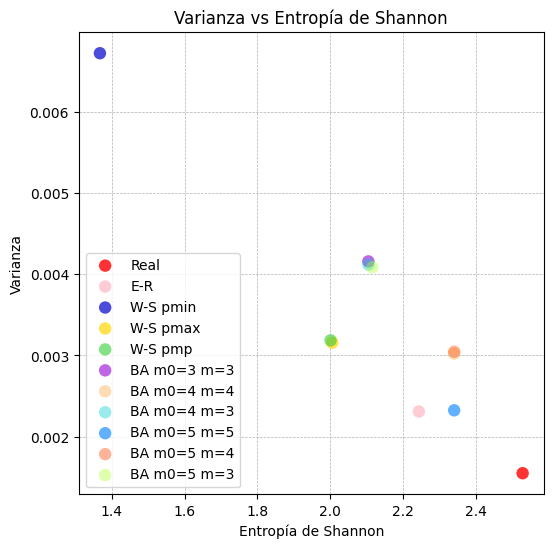

In [ ]:
colores = ['red', 'pink', 'mediumblue', 'gold', 'limegreen', 'darkviolet', 'darkorange', 'darkturquoise', 'dodgerblue', 'orangered', 'greenyellow' ]
plt.figure(figsize = [6,6])

for i in range(len(Entropy)):
  plt.scatter(Entropy[i], Varianza[i], c=colores[i] , s= 80, marker='o', alpha = trans[i], label=nombres[i], edgecolor='none')

plt.xlabel('Entropía de Shannon')
plt.ylabel('Varianza')
plt.title('Varianza vs Entropía de Shannon')

plt.grid(linestyle='--', linewidth=0.5)
plt.legend(loc = 'lower left')


# Estilo de la tabla
#tabla.auto_set_font_size(False)
#tabla.set_fontsize(10)
#tabla.scale(1, 1.2)  # Ajustar el tamaño de la tabla según tus necesidades

# Crear una leyenda vacía para agregar espacio
#plt.legend(handles=[], labels=[])


plt.show()

In [ ]:
from scipy.stats import binom

N = 44
p = 0.1427061310782241
k_values = np.arange(0, N - 1)
probabilidades = binom.pmf(k_values, N, p)

In [ ]:
argR = [DP_Real[i] * np.log(DP_Real[i] / probabilidades[i]) for i in range(len(DP_Real)) if DP_Real[i] != 0]
Dis_KLR = np.sum(argR)
argER = [DP_ER[i] * np.log(DP_ER[i] / probabilidades[i]) for i in range(len(DP_ER)) if DP_ER[i] != 0]
Dis_KLER = np.sum(argER)
argWS1 = [DP_WSpmin[i] * np.log(DP_WSpmin[i] / probabilidades[i]) for i in range(len(DP_WSpmin)) if DP_WSpmin[i] != 0]
Dis_KLWS1 = np.sum(argWS1)
argWS2 = [DP_WSpmax[i] * np.log(DP_WSpmax[i] / probabilidades[i]) for i in range(len(DP_WSpmax)) if DP_WSpmax[i] != 0]
Dis_KLWS2 = np.sum(argWS2)
argWS3 = [DP_WSpmp[i] * np.log(DP_WSpmp[i] / probabilidades[i]) for i in range(len(DP_WSpmp)) if DP_WSpmp[i] != 0]
Dis_KLWS3 = np.sum(argWS3)
argB1 = [DP_BA33[i] * np.log(DP_BA33[i] / probabilidades[i]) for i in range(len(DP_BA33)) if DP_BA33[i] != 0]
Dis_KLB1 = np.sum(argB1)
argB2 = [DP_BA44[i] * np.log(DP_BA44[i] / probabilidades[i]) for i in range(len(DP_BA44)) if DP_BA44[i] != 0]
Dis_KLB2 = np.sum(argB2)
argB3 = [DP_BA43[i] * np.log(DP_BA43[i] / probabilidades[i]) for i in range(len(DP_BA43)) if DP_BA43[i] != 0]
Dis_KLB3 = np.sum(argB3)
argB4 = [DP_BA55[i] * np.log(DP_BA55[i] / probabilidades[i]) for i in range(len(DP_BA55)) if DP_BA55[i] != 0]
Dis_KLB4 = np.sum(argB4)
argB5 = [DP_BA54[i] * np.log(DP_BA54[i] / probabilidades[i]) for i in range(len(DP_BA54)) if DP_BA54[i] != 0]
Dis_KLB5 = np.sum(argB5)
argB6 = [DP_BA53[i] * np.log(DP_BA53[i] / probabilidades[i]) for i in range(len(DP_BA53)) if DP_BA53[i] != 0]
Dis_KLB6 = np.sum(argB6)

DKL = [[Dis_KLR, Dis_KLER, Dis_KLWS1, Dis_KLWS2, Dis_KLWS3, Dis_KLB1, Dis_KLB2, Dis_KLB3, Dis_KLB4, Dis_KLB5, Dis_KLB6]]

column_headers = ["Real", "E-R", "W-S pmin", "W-S pmax", "W-S pmp", "B1", "B2", "B3", "B4", "B5", "B6"]
row_headers = ["Distancia K-L ref: Binomial"]

Tabla_KLBin = pd.DataFrame(DKL, columns=column_headers, index=row_headers)
Tabla_KLBin

,Real,E-R,W-S pmin,W-S pmax,W-S pmp,B1,B2,B3,B4,B5,B6
Distancia K-L ref: Binomial,0.48041,0.002074,0.478956,0.058345,0.060908,0.87246,1.04064,0.862395,1.750462,1.063987,0.889613


In [ ]:
#Creando los arreglos de distribuciones de probabilidad acumuladas
#Real
cc = 0
cumulative = []
for i in range(43):
  cc = cc + DP_Real[i]
  cumulative.append(cc)

#E-R
ccER = 0
cumulativeER = []
for i in range(43):
  ccER = ccER + DP_ER[i]
  cumulativeER.append(ccER)

#W-S pmin
ccWS1 = 0
cumulativeWS1 = []
for i in range(43):
  ccWS1 = ccWS1 + DP_WSpmin[i]
  cumulativeWS1.append(ccWS1)

#W-S pmax
ccWS2 = 0
cumulativeWS2 = []
for i in range(43):
  ccWS2 = ccWS2 + DP_WSpmax[i]
  cumulativeWS2.append(ccWS2)

#W-S pmp
ccWS3 = 0
cumulativeWS3 = []
for i in range(43):
  ccWS3 = ccWS3 + DP_WSpmp[i]
  cumulativeWS3.append(ccWS3)

#B1
ccB1 = 0
cumulativeB1 = []
for i in range(43):
  ccB1 = ccB1 + DP_BA33[i]
  cumulativeB1.append(ccB1)

#B2
ccB2 = 0
cumulativeB2 = []
for i in range(43):
  ccB2 = ccB2 + DP_BA44[i]
  cumulativeB2.append(ccB2)

#B3
ccB3 = 0
cumulativeB3 = []
for i in range(43):
  ccB3 = ccB3 + DP_BA43[i]
  cumulativeB3.append(ccB3)

#B4
ccB4 = 0
cumulativeB4 = []
for i in range(43):
  ccB4 = ccB4 + DP_BA55[i]
  cumulativeB4.append(ccB4)

#B5
ccB5 = 0
cumulativeB5 = []
for i in range(43):
  ccB5 = ccB5 + DP_BA54[i]
  cumulativeB5.append(ccB5)

#B6
ccB6 = 0
cumulativeB6 = []
for i in range(43):
  ccB6 = ccB6 + DP_BA53[i]
  cumulativeB6.append(ccB6)

In [ ]:
plt.figure(figsize = [7,7])

for i in range(len(DKL)):
  plt.scatter(DKL[i], abs_DKL_A[i], c=colores[i] , s= size[i], marker='o', alpha = trans[i], label=nombres[i], edgecolor='none')

plt.xlabel('Distancia de Kullback-Leibler de los modelos respecto a una distribución binomial')
plt.ylabel('Distancia de Kullback-Leibler Acumulada')
plt.title('DKL vs DKL Acumulada')

NameError: ignored

<Figure size 700x700 with 0 Axes>

In [ ]:
rgER = [cumulativeER[i] * np.log(cumulativeER[i] / cumulative[i]) for i in range(len(cumulativeER)) if cumulativeER[i] != 0]
DisA_KLER = np.sum(rgER)
rgWS1 = [cumulativeWS1[i] * np.log(cumulativeWS1[i] / cumulative[i]) for i in range(len(cumulativeWS1)) if cumulativeWS1[i] != 0]
DisA_KLWS1 = np.sum(rgWS1)
rgWS2 = [cumulativeWS2[i] * np.log(cumulativeWS2[i] / cumulative[i]) for i in range(len(cumulativeWS2)) if cumulativeWS2[i] != 0]
DisA_KLWS2 = np.sum(rgWS2)
rgWS3 = [cumulativeWS3[i] * np.log(cumulativeWS3[i] / cumulative[i]) for i in range(len(cumulativeWS3)) if cumulativeWS3[i] != 0]
DisA_KLWS3 = np.sum(rgWS3)
rgB1 = [cumulativeB1[i] * np.log(cumulativeB1[i] / cumulative[i]) for i in range(len(cumulativeB1)) if cumulativeB1[i] != 0]
DisA_KLB1 = np.sum(rgB1)
rgB2 = [cumulativeB2[i] * np.log(cumulativeB2[i] / cumulative[i]) for i in range(len(cumulativeB2)) if cumulativeB2[i] != 0]
DisA_KLB2 = np.sum(rgB2)
rgB3 = [cumulativeB3[i] * np.log(cumulativeB3[i] / cumulative[i]) for i in range(len(cumulativeB3)) if cumulativeB3[i] != 0]
DisA_KLB3 = np.sum(rgB3)
rgB4 = [cumulativeB4[i] * np.log(cumulativeB4[i] / cumulative[i]) for i in range(len(cumulativeB4)) if cumulativeB4[i] != 0]
DisA_KLB4 = np.sum(rgB4)
rgB5 = [cumulativeB5[i] * np.log(cumulativeB5[i] / cumulative[i]) for i in range(len(cumulativeB5)) if cumulativeB5[i] != 0]
DisA_KLB5 = np.sum(rgB5)
rgB6 = [cumulativeB6[i] * np.log(cumulativeB6[i] / cumulative[i]) for i in range(len(cumulativeB6)) if cumulativeB6[i] != 0]
DisA_KLB6 = np.sum(rgB6)

DKL_A = [[DisA_KLER, DisA_KLWS1, DisA_KLWS2, DisA_KLWS3, DisA_KLB1, DisA_KLB2, DisA_KLB3, DisA_KLB4, DisA_KLB5, DisA_KLB6]]

column_headers = ["E-R", "W-S pmin", "W-S pmax", "W-S pmp", "B1", "B2", "B3", "B4", "B5", "B6"]
row_headers = ["Distancia K-L acumulada ref: Real"]

Tabla_KLC = pd.DataFrame(DKL_A, columns=column_headers, index=row_headers)
Tabla_KLC

,E-R,W-S pmin,W-S pmax,W-S pmp,B1,B2,B3,B4,B5,B6
Distancia K-L acumulada ref: Real,0.222132,1.06123,0.558204,0.564518,0.867669,-0.802563,0.866909,-2.036808,-0.802913,0.818771


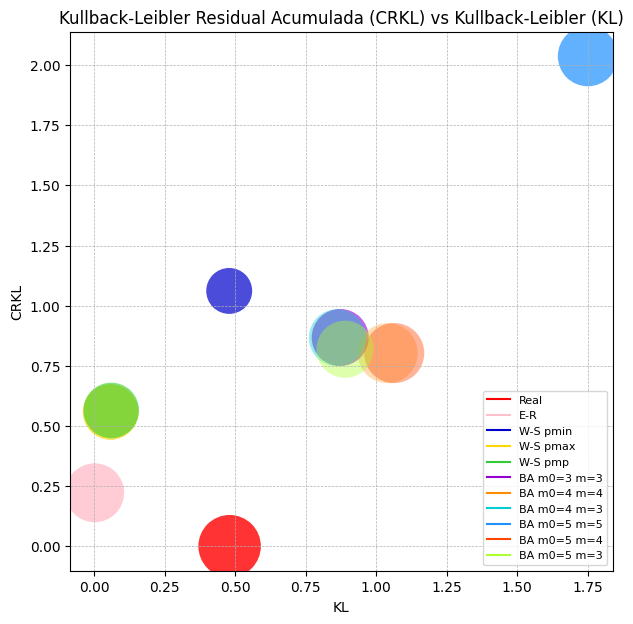

In [ ]:
from matplotlib.lines import Line2D
DKL_Cumulative = np.array(DKL_A)
abs_DKL_A = np.abs(DKL_Cumulative)
abs_DKL_A = abs_DKL_A.reshape(10)
abs_DKL_A = np.insert(abs_DKL_A, 0, 0)
DKL = np.array(DKL)
DKL = DKL.reshape(11)
Entropy = np.array(Entropy)
Entropy = Entropy.reshape(11)
size = 800*Entropy
colores = ['red', 'pink', 'mediumblue', 'gold', 'limegreen', 'darkviolet', 'darkorange', 'darkturquoise', 'dodgerblue', 'orangered', 'greenyellow' ]
nombres = ['Real', 'E-R',	'W-S pmin',	'W-S pmax',	'W-S pmp', 'BA m0=3 m=3', 'BA m0=4 m=4', 'BA m0=4 m=3',  'BA m0=5 m=5',  'BA m0=5 m=4', 'BA m0=5 m=3'	]
trans = [0.8, 0.8, 0.7, 0.7, 0.6, 0.6, 0.3, 0.4, 0.7, 0.4, 0.4]
tam = 0.3

plt.figure(figsize = [7,7])

for i in range(len(DKL)):
  plt.scatter(DKL[i], abs_DKL_A[i], c=colores[i] , s= size[i], marker='o', alpha = trans[i], label=nombres[i], edgecolor='none')

plt.xlabel('KL')
plt.ylabel('CRKL')
plt.title('Kullback-Leibler Residual Acumulada (CRKL) vs Kullback-Leibler (KL)')

#for i, (DKLi, abs_DKL_Ai) in enumerate(zip(DKL, abs_DKL_A)):
    #plt.annotate(f'({DKLi: .2f},{abs_DKL_Ai: .2f})', (DKLi, abs_DKL_Ai), textcoords='offset points', xytext=(5,5), ha='center', fontsize=8)

plt.grid(linestyle='--', linewidth=0.5)
legend_elements = [Line2D([0], [0], linestyle='-', color=colores[i], label=nombres[i], markersize=10) for i in range(len(DKL))]
plt.legend(handles=legend_elements, loc='lower right', fontsize=8)

plt.show()